In [1]:
student_Name='Bobb Shields'
student_ID='wde677'
dataset_URL='https://www.kaggle.com/datasets/sheacon/tn-mvr-2018-2022'

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split


Noting changes made 4/4 due to mistakes in data prep.  "HINO" is a commercial truck manufacturer, so removed from imports category, pushing it into other.  And the sports mask was showing the imports group - corrected that typo.  

4/29 Update - Dropped commercial trucks and winnebagos that dont' fit the cars + trucks schema.  These were supposed to have been dropped in filtering down on type variable. Removed the max price on luxury vehicles.  Dropped non-luxury maximum to 250k.  Changes made in Data Prep notebook, iterated the filename to v3. 

Filters have been applied to reduce this to automobiles only, less than 500k miles, less than 100 years old, less than $10mil, 

Things need to be checked.  MERC and MERZ fixed in download but look for further duplicates.  Model A's shown in these transactions so maybe an age limit is appropriate.  Not sure that a Nissan Altima will appreciate the same way as a Model A lol 

Check for duplicate records per VIN and look at historical trends <- Stretch goal, struggling 4/17

Treat new car price averages as maximum, unless luxury/discontinued brings a postitive curve due to antique-ness <-Still brewing


In [2]:
import time
startTime = time.time()
mostRecentTime = startTime

nowish = (time.time() - startTime)
print('Start time: ' + str(nowish))
print("(in seconds)")

Start time: 0.0005068778991699219
(in seconds)


In [3]:
#have filtered down the project dataset 
tn_auto_reg_f = pd.read_csv('tn_auto_reg_filtered_CT3.csv',low_memory=False)
tn_auto_reg_f.describe().round()

,price,odometer_type,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK,new_used_N,new_used_U
count,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0
mean,22557.0,0.0,69581.0,2015.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
std,22198.0,1.0,66420.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,300.0,0.0,1.0,1915.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,7500.0,0.0,8525.0,2012.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
50%,18500.0,0.0,54849.0,2016.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
75%,32328.0,0.0,113099.0,2019.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
max,9534253.0,9.0,750000.0,2023.0,105.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Data loaded: ' + str(round(nowish,0)) )
print("Last section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Data loaded: 10.0
Last section took: 10.0
(in seconds)


In [5]:
# Define mask variables
mask_popular = tn_auto_reg_f['make_cat_popular'] == 1
mask_sports = tn_auto_reg_f['make_cat_sports'] == 1
mask_imports = tn_auto_reg_f['make_cat_imports'] == 1
mask_luxury = tn_auto_reg_f['make_cat_luxury'] == 1
mask_discontinued = tn_auto_reg_f['make_cat_discontinued'] == 1
mask_other = tn_auto_reg_f['make_cat_other'] == 1
mask_auto = tn_auto_reg_f['type_AUTO'] == 1
mask_truck = tn_auto_reg_f['type_TRUCK'] == 1
mask_new = tn_auto_reg_f['new_used_N'] == 1
mask_used = tn_auto_reg_f['new_used_U'] == 1

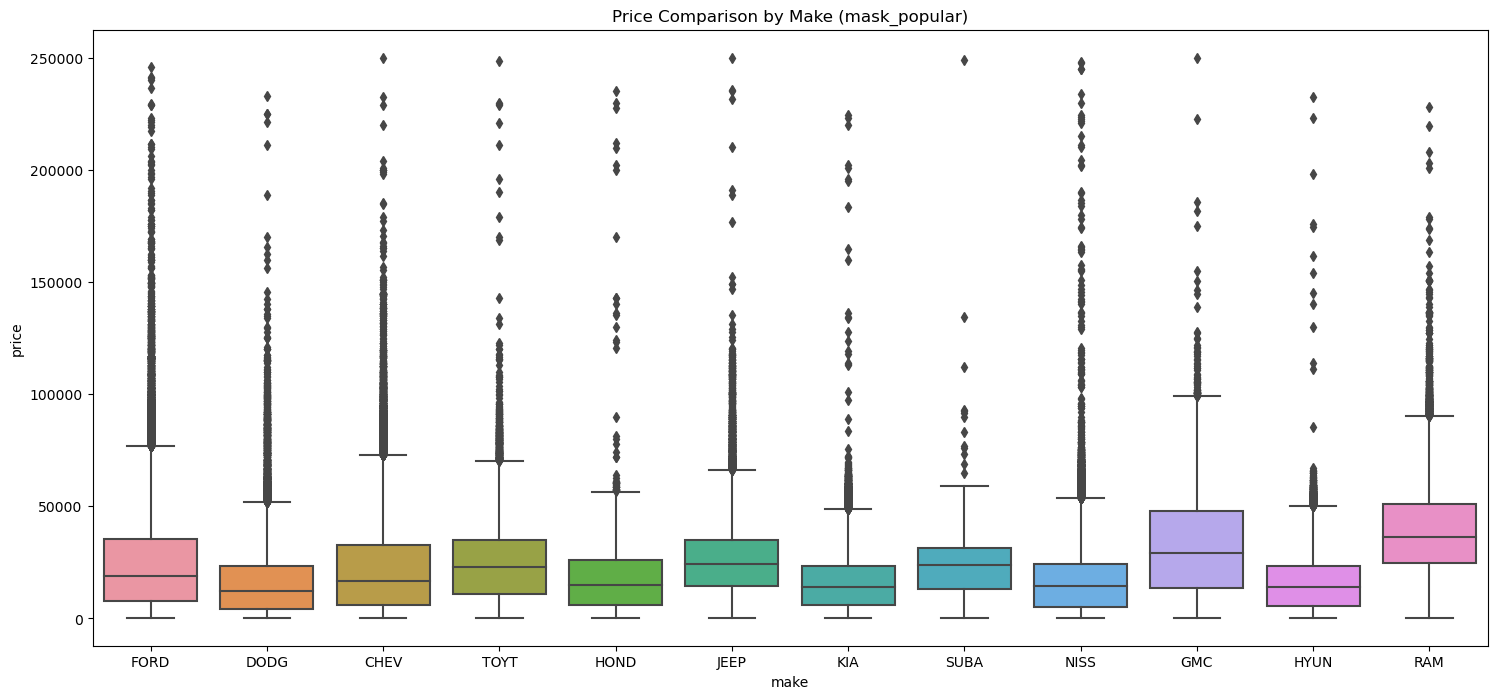

In [6]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_popular])
plt.title("Price Comparison by Make (mask_popular)")
plt.show()

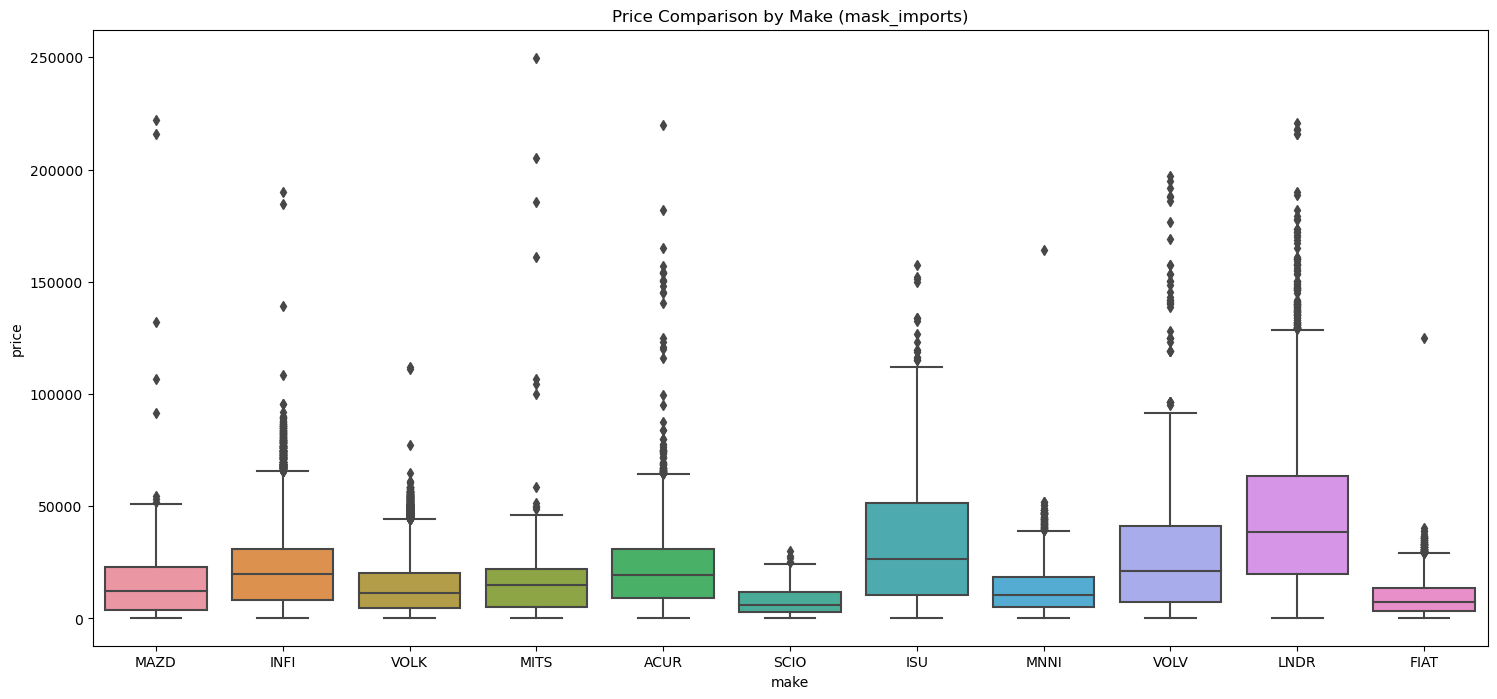

In [7]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_imports])
plt.title("Price Comparison by Make (mask_imports)")
plt.show()

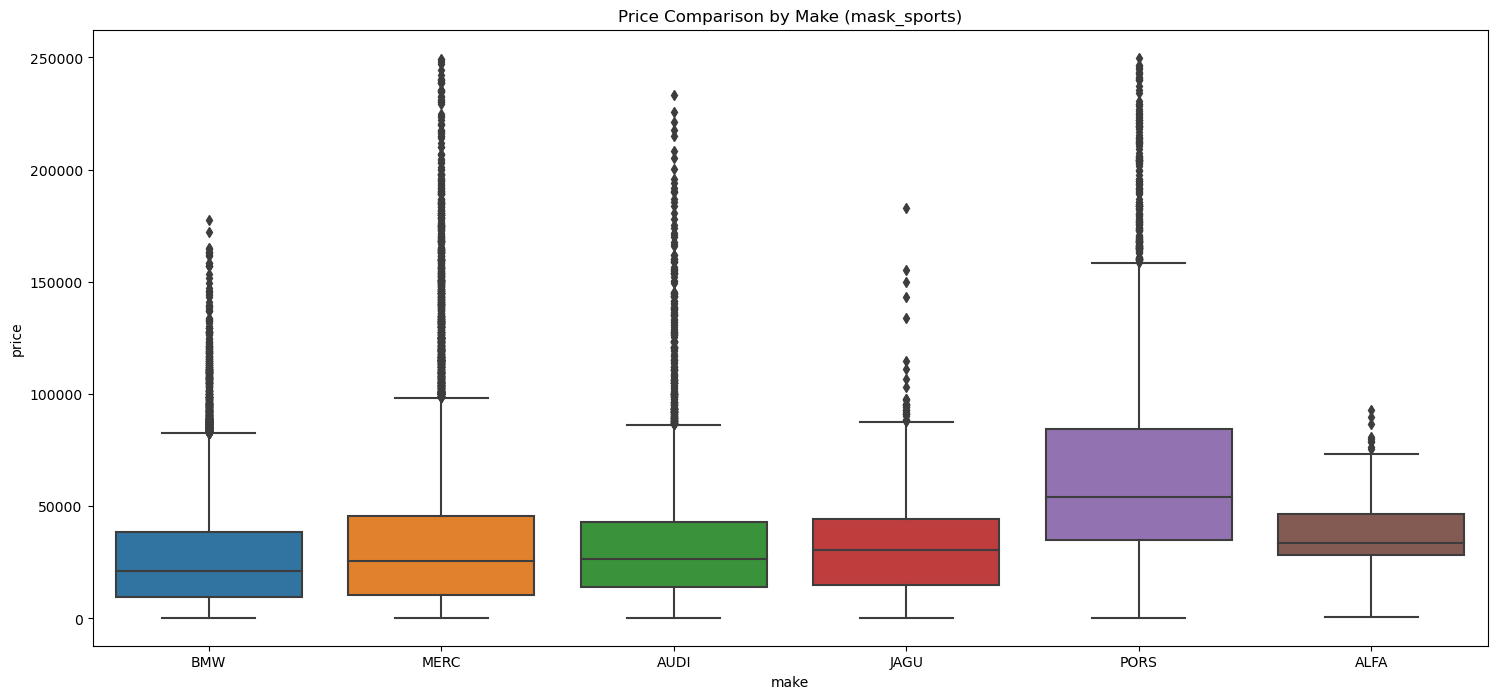

In [8]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_sports])
plt.title("Price Comparison by Make (mask_sports)")
plt.show()

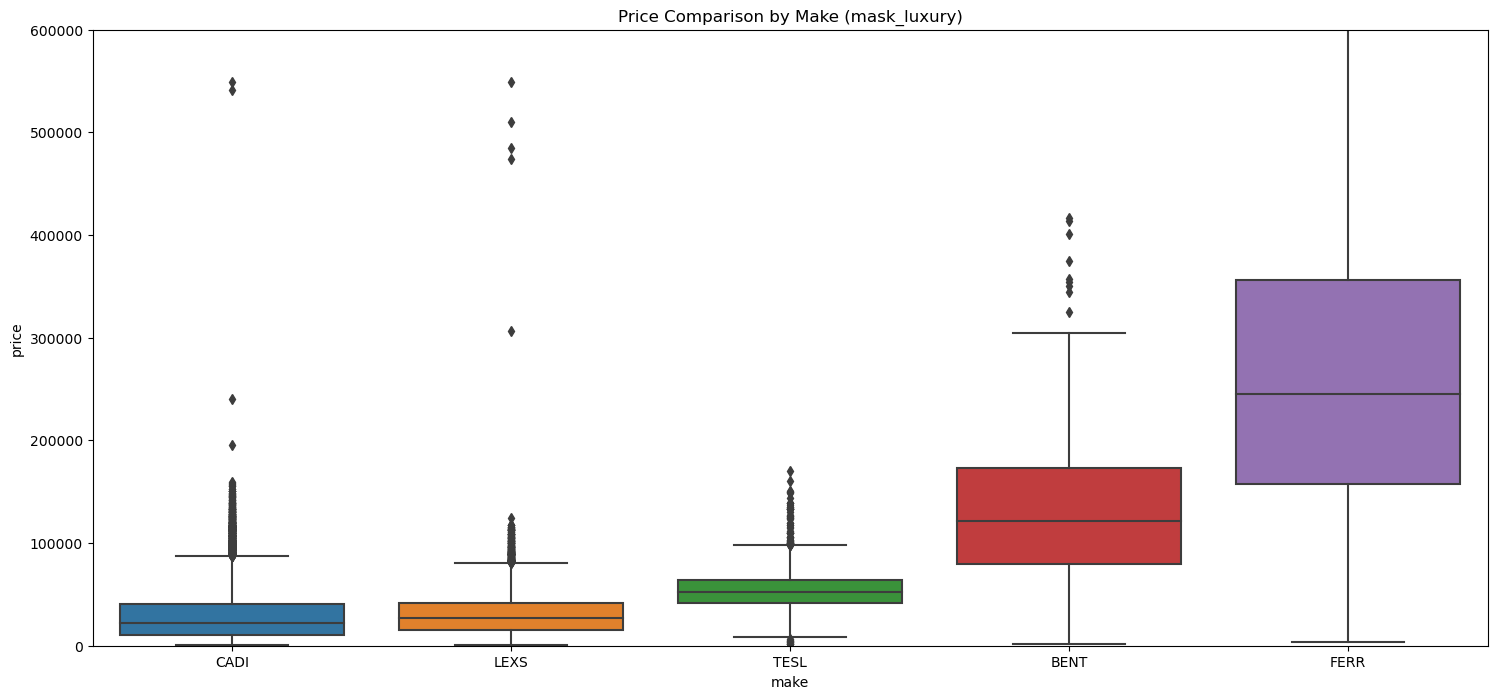

In [9]:
plt.figure(figsize=(18,8))
ax = sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_luxury])
ax.set_ylim([0, 600000])
plt.title("Price Comparison by Make (mask_luxury)")
plt.show()

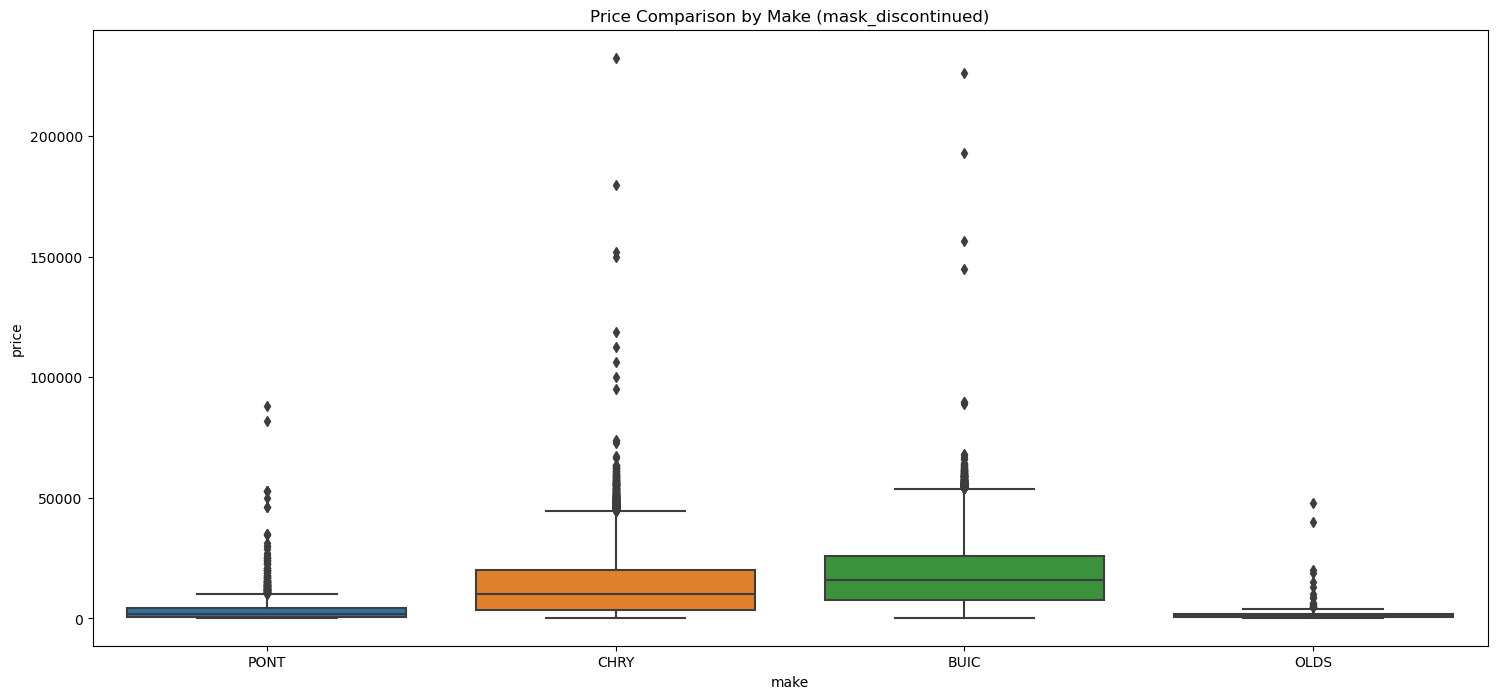

In [10]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_discontinued])
plt.title("Price Comparison by Make (mask_discontinued)")
plt.show()

Number of results: 10920


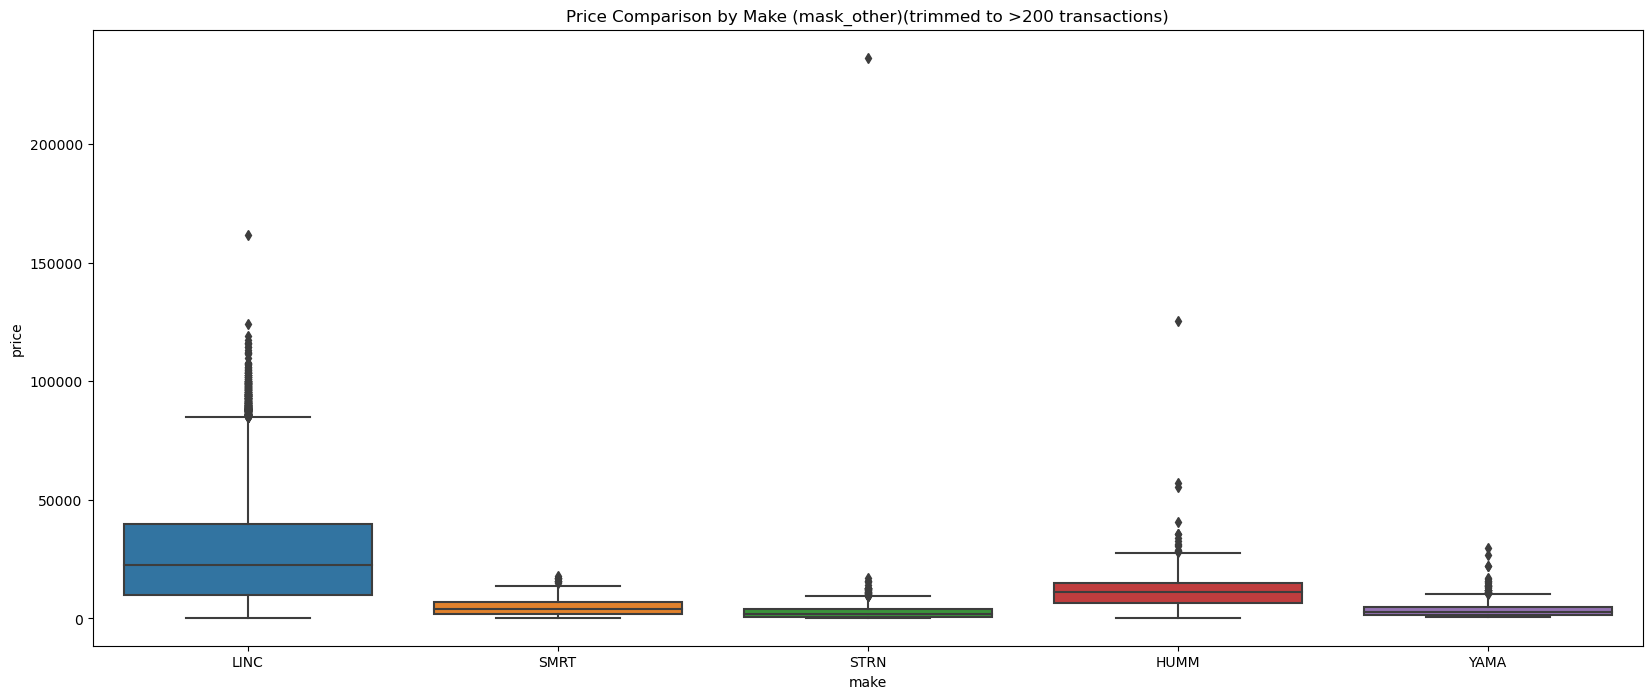

In [11]:
#trimming this down to significant data points (more than 200 transactions)
make_counts = tn_auto_reg_f['make'].value_counts()
mask_make_counts = tn_auto_reg_f['make'].isin(make_counts[make_counts > 200].index)

#boxplot like all the other masks above
plt.figure(figsize=(20,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_other & mask_make_counts])
print("Number of results: " + str(len(tn_auto_reg_f[mask_other & mask_make_counts])))
plt.title("Price Comparison by Make (mask_other)(trimmed to >200 transactions)")
plt.show()

In [12]:
# determine an average price for each make/model for both new and used vehicles
avg_price = tn_auto_reg_f.groupby(['make', 'model', 'new_used_N'])['price'].mean().reset_index()
avg_price = avg_price.pivot_table(index=['make', 'model'], columns='new_used_N', values='price', aggfunc='first').reset_index()
avg_price.columns.name = None
avg_price = avg_price[['make', 'model', 1, 0]]

# filter to only rows with non-null values in both 'new' and 'used' columns
avg_price_filtered = avg_price[avg_price[[1, 0]].notnull().all(axis=1)]

# change column names 
avg_price_filtered = avg_price_filtered.rename(columns={'1': 'new_avg', '0': 'used_avg'})

print("Average prices shown below: 1 is New, 0 is Used")
print(avg_price_filtered.sample(20).round(0))

print("Seeing some models go up on average.")

Average prices shown below: 1 is New, 0 is Used
      make model        1        0
4274  JEEP   RAN  54186.0  20718.0
5215  MERC   GLB  49050.0  41663.0
1143  CHEV   COL  31765.0  11162.0
6215   RAM    CB  45967.0  49509.0
1338  CHEV   KL8  16163.0   9084.0
5119  MERC   C63  87766.0  31072.0
5789  NISS   RG3  24325.0  17784.0
5731  NISS   LEA  36858.0   8493.0
743   CADI   ATS  39168.0  16688.0
6167   RAM   3C7  72243.0  41718.0
3397  HOND   CB6   6417.0    675.0
6844  TOYT   RAV  33111.0  20961.0
1732  DODG   250  52065.0  17060.0
6226   RAM   CRW  54637.0  37896.0
6216   RAM    CC  58504.0  20497.0
1739  DODG   2C4  23405.0  12334.0
6475  SUBA   JF1  31978.0  10246.0
1532  CHEV   TRL  30444.0   2529.0
4439   KIA   LXS  26995.0  24386.0
4558  LEXS   350  49905.0  22745.0
Seeing some models go up on average.


C:\Users\bobbs\AppData\Local\Temp\ipykernel_15888\3464386721.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['New', 'Used'])


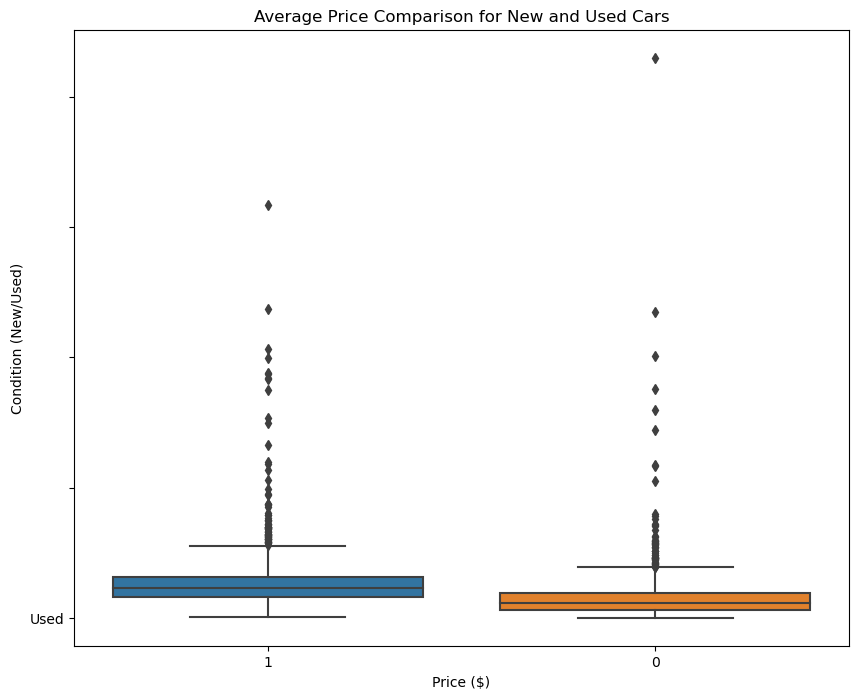

In [13]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10,8))

# Plot boxplots for new and used cars side by side
sns.boxplot(data=avg_price_filtered[[1, 0]],  ax=ax)

# Set title and axis labels
ax.set_title("Average Price Comparison for New and Used Cars")
ax.set_xlabel("Price ($)")
ax.set_ylabel("Condition (New/Used)")
ax.set_yticklabels(['New', 'Used'])

# Show plot
plt.show()

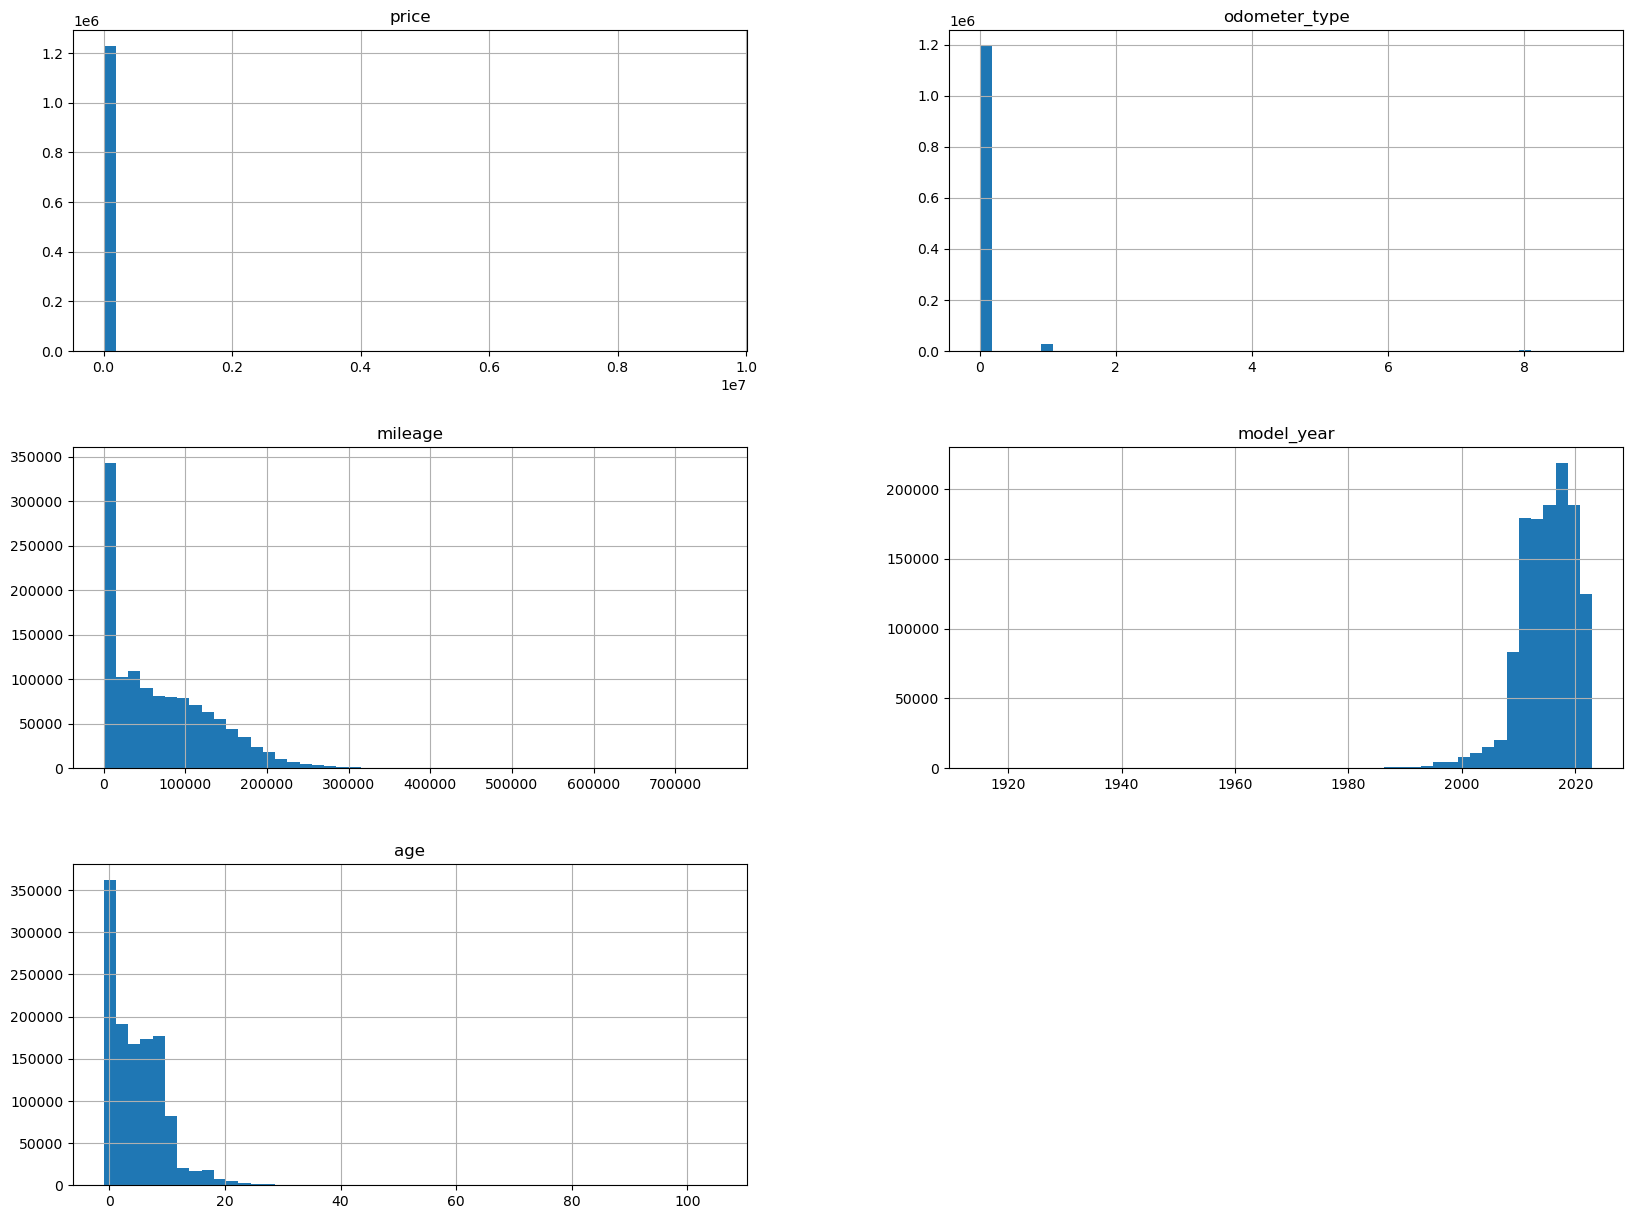

Price, mileage, and age are confirmed by corr analysis to be strong indicators.
Striving for a normal distribution will take some work


In [14]:
tn_auto_reg_f[["price","odometer_type","mileage","model_year","age"]].hist(bins=50, figsize=(20,15))
plt.show()
print("Price, mileage, and age are confirmed by corr analysis to be strong indicators.")
print("Striving for a normal distribution will take some work")

In [15]:
tn_auto_reg_f['price_log'] = np.log1p(tn_auto_reg_f['price'])
tn_auto_reg_f['mileage_log'] = np.log1p(tn_auto_reg_f['mileage'])


Log(age) didn't compute and model year didn't look any different.  Left them alone

Showing transformations on right side that will be prefered in ML algorithm


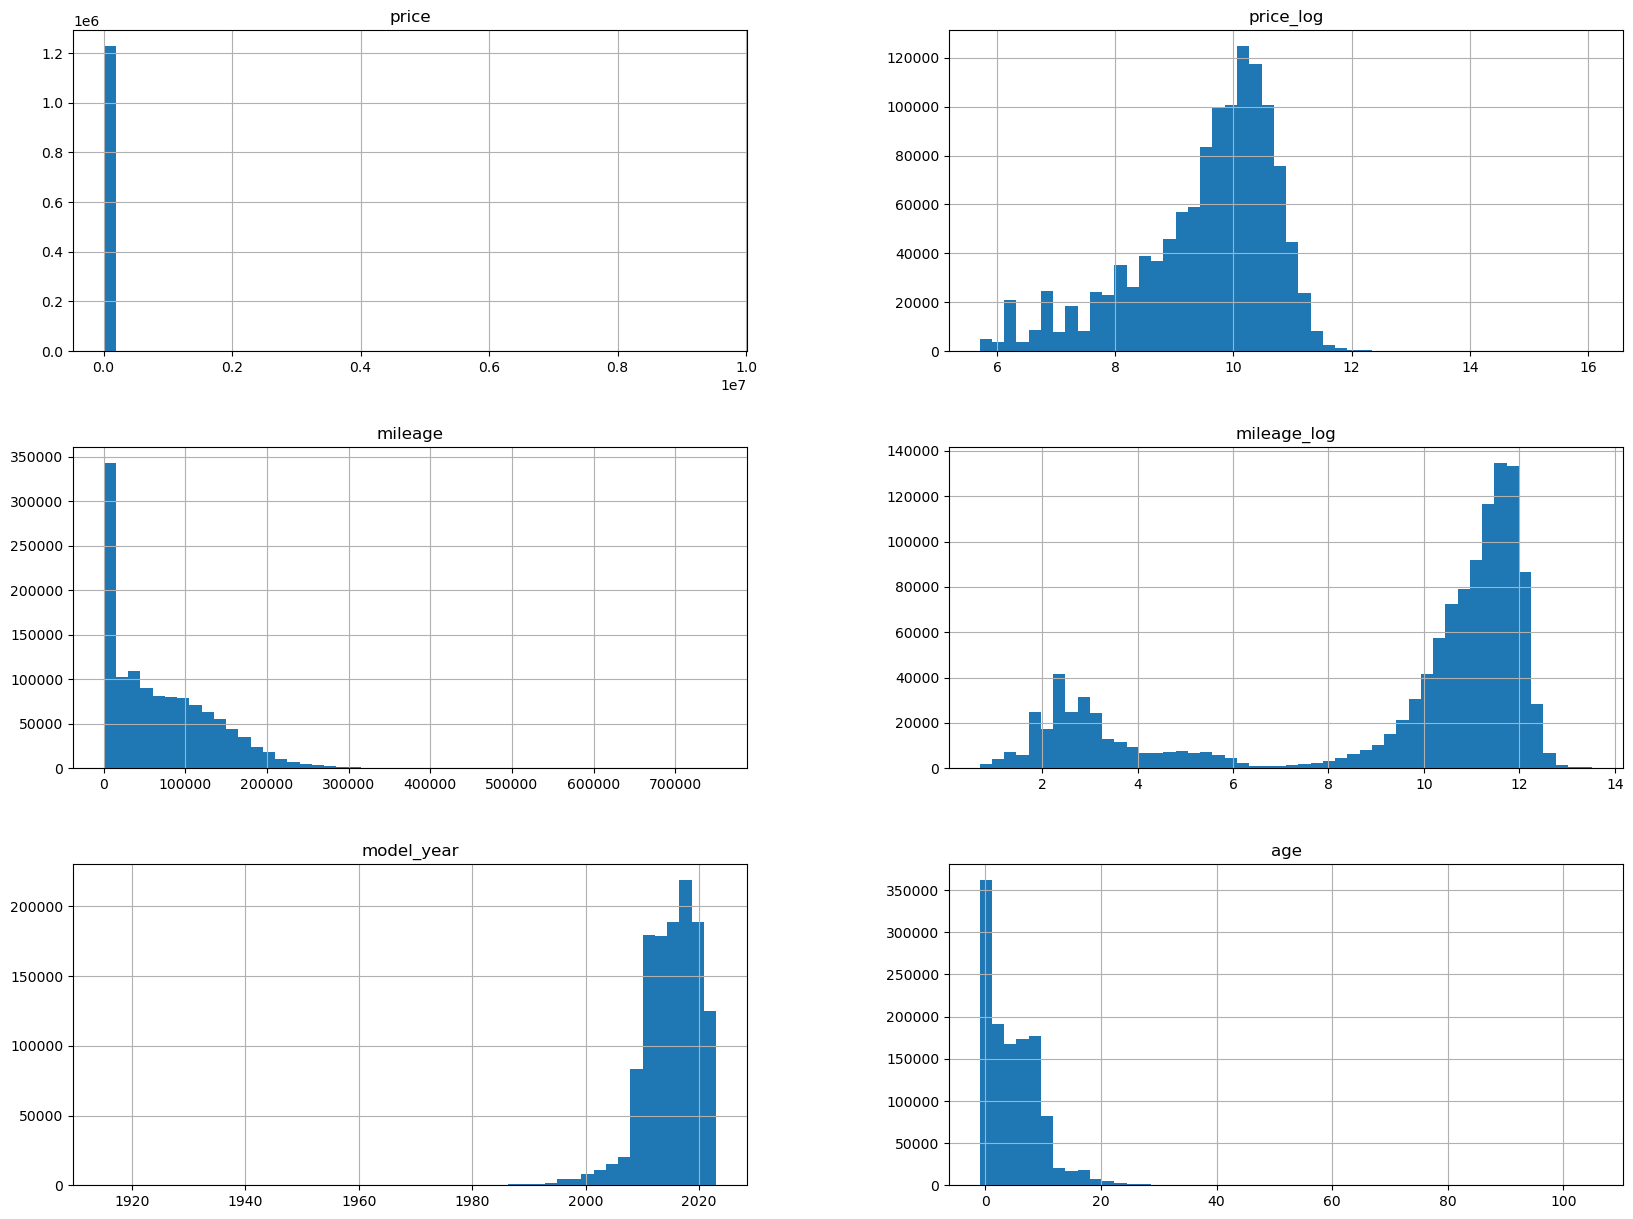

In [16]:
print("Showing transformations on right side that will be prefered in ML algorithm")
tn_auto_reg_f[["price","price_log","mileage","mileage_log","model_year","age"]].hist(bins=50, figsize=(20,15))
plt.show()

In [17]:
# Sort by VIN
sorted = tn_auto_reg_f.sort_values(by=['vin','title_issue_date'])

# Count the number of records per VIN 
vin_counts = sorted['vin'].value_counts()

# Exclude any cars with less than 2 records
multiple_vins = vin_counts[vin_counts > 3].index

sorted = sorted[sorted['vin'].isin(multiple_vins)] #refactor here? 
print("Number of VINs with more than 3 records:", len(multiple_vins))

Number of VINs with more than 3 records: 1276


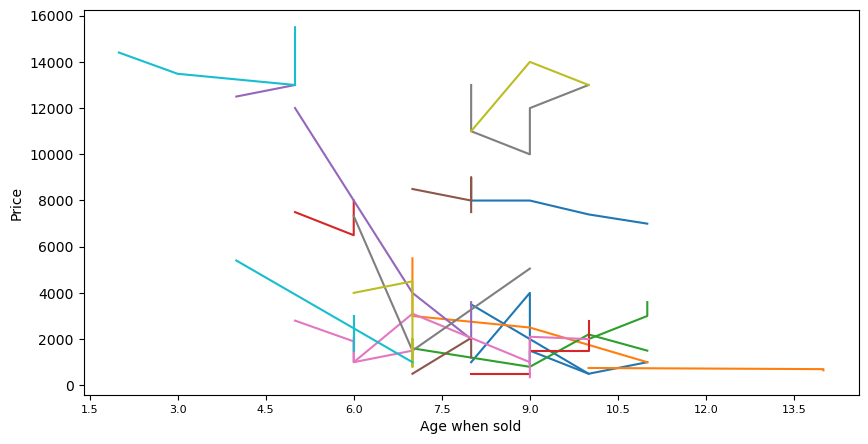

In [18]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Group by VIN and create a dictionary where the keys are the VINs and the values are DataFrames
# containing the purchase date and price for each VIN

# Slice the middle 200 entries
start_idx = 80 #(len(sorted) - 100) // 2
end_idx = start_idx + 100
grouped = sorted.iloc[start_idx:end_idx]
grouped = grouped.groupby('vin')


vin_data = {vin: data[['age', 'price']] for vin, data in grouped}

# Create a color map for the plot
color_map = plt.get_cmap('tab10', len(vin_data))

# Plot each VIN's data as a separate line with a different color
fig, ax = plt.subplots( figsize=(10, 5) )
for i, (vin, data) in enumerate(vin_data.items()):
    color = color_map(i)

    ax.plot(data['age'], data['price'], label=vin, color=color)

# Format the x-axis to show years and months
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

ax.tick_params(axis='x', which='major', labelsize=8) # Set the font size of x-axis labels
    
    # Add a legend and axis labels
#ax.legend()
ax.set_xlabel('Age when sold')
ax.set_ylabel('Price')
plt.show()


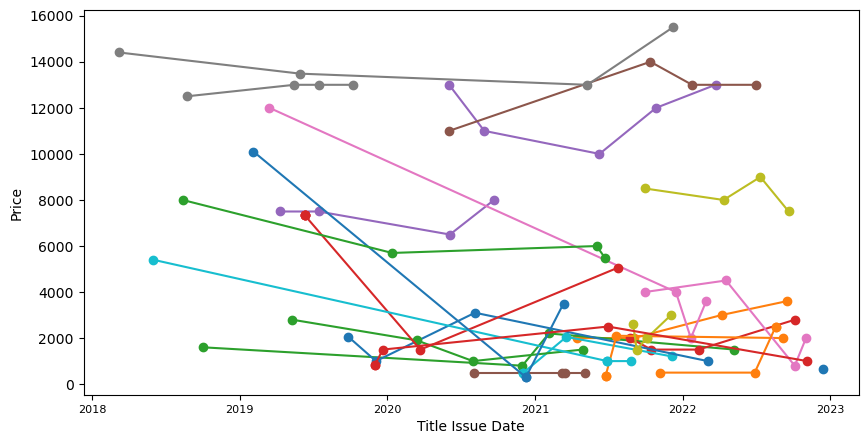

In [19]:
# Plot scatterplot with lines connecting records for each VIN
fig, ax = plt.subplots( figsize=(10, 5) )

current_vin = None
current_x = None
current_y = None

for index, row in sorted.iloc[100:200].iterrows():
    if row['vin'] != current_vin:
        if current_x is not None and current_y is not None:
            ax.plot(current_x, current_y, marker='o' )#label=current_vin, )
        current_vin = row['vin']
        current_x = [pd.to_datetime(row['title_issue_date'])]
        current_y = [row['price']]
    else:
        current_x.append(pd.to_datetime(row['title_issue_date']))
        current_y.append(row['price'])

# Add legend and axis labels
#ax.legend()
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
ax.tick_params(axis='x', which='major', labelsize=8) # Set the font size of x-axis labels

ax.set_xlabel('Title Issue Date')
ax.set_ylabel('Price')
plt.show()

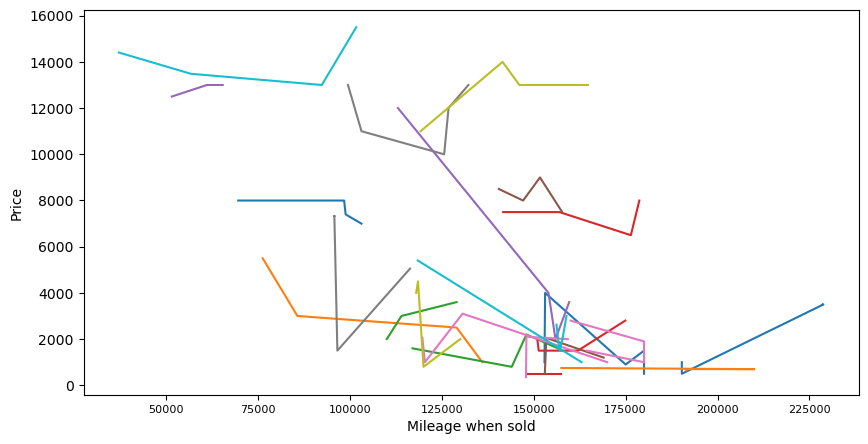

In [20]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Group by VIN and create a dictionary where the keys are the VINs and the values are DataFrames
# containing the purchase date and price for each VIN

# Slice the middle 200 entries
start_idx = 80 #(len(sorted) - 100) // 2
end_idx = start_idx + 100
grouped = sorted.iloc[start_idx:end_idx]
grouped = grouped.groupby('vin')


vin_data = {vin: data[['mileage', 'price']] for vin, data in grouped}

# Create a color map for the plot
color_map = plt.get_cmap('tab10', len(vin_data))

# Plot each VIN's data as a separate line with a different color
fig, ax = plt.subplots( figsize=(10, 5) )
for i, (vin, data) in enumerate(vin_data.items()):
    color = color_map(i)

    ax.plot(data['mileage'], data['price'], label=vin, color=color)

# Format the x-axis to show years and months
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

ax.tick_params(axis='x', which='major', labelsize=8) # Set the font size of x-axis labels
    
    # Add a legend and axis labels
#ax.legend()
ax.set_xlabel('Mileage when sold')
ax.set_ylabel('Price')
plt.show()


In [21]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Analysis completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Analysis completed (total time): 37.0
This section took: 27.0
(in seconds)


            price  mileage   age  new_used_N  type_TRUCK
price        1.00    -0.53 -0.52        0.43        0.19
mileage     -0.53     1.00  0.69       -0.50        0.03
age         -0.52     0.69  1.00       -0.49       -0.01
new_used_N   0.43    -0.50 -0.49        1.00        0.05
type_TRUCK   0.19     0.03 -0.01        0.05        1.00


<AxesSubplot: title={'center': 'Population - New/Used Cars/Trucks'}>

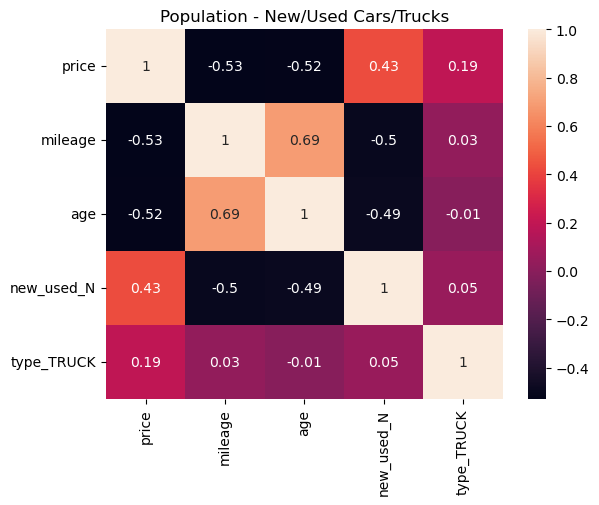

In [22]:
#overall corr analysis
tn_auto_reg_f_hm = tn_auto_reg_f[["price","mileage","age",'new_used_N',"type_TRUCK"]].corr().round(2)
print(tn_auto_reg_f_hm)
plt.title("Population - New/Used Cars/Trucks")
sns.heatmap(tn_auto_reg_f_hm, annot=True)


Below begins the ML Regression 

In [23]:
tn_auto_reg_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231111 entries, 0 to 1231110
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   vin                    1231111 non-null  object 
 1   price                  1231111 non-null  float64
 2   odometer_type          1231111 non-null  int64  
 3   mileage                1231111 non-null  int64  
 4   county                 1231111 non-null  object 
 5   zip                    1231111 non-null  object 
 6   model_year             1231111 non-null  int64  
 7   make                   1231111 non-null  object 
 8   model                  1231111 non-null  object 
 9   vehicle_type           1231111 non-null  object 
 10  new_used               1231111 non-null  object 
 11  title_issue_date       1231111 non-null  object 
 12  purchase_date          1231111 non-null  object 
 13  age                    1231111 non-null  int64  
 14  make_cat_popular  

In [24]:
print("Dropping all non-feature columns\n")
dropped = tn_auto_reg_f.drop("vin", axis=1)
dropped = dropped.drop("odometer_type", axis=1)
dropped = dropped.drop("county", axis=1)
dropped = dropped.drop("zip", axis=1)
dropped = dropped.drop("model_year", axis=1)
dropped = dropped.drop("make", axis=1)
dropped = dropped.drop("model", axis=1)
dropped = dropped.drop("vehicle_type", axis=1)
dropped = dropped.drop("new_used", axis=1)
dropped = dropped.drop("title_issue_date", axis=1)
dropped = dropped.drop("purchase_date", axis=1)
dropped = dropped.drop("mileage", axis=1)
dropped = dropped.drop("price", axis=1)


dropped.info()

Dropping all non-feature columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231111 entries, 0 to 1231110
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   age                    1231111 non-null  int64  
 1   make_cat_popular       1231111 non-null  int64  
 2   make_cat_imports       1231111 non-null  int64  
 3   make_cat_sports        1231111 non-null  int64  
 4   make_cat_luxury        1231111 non-null  int64  
 5   make_cat_discontinued  1231111 non-null  int64  
 6   make_cat_other         1231111 non-null  int64  
 7   type_AUTO              1231111 non-null  int64  
 8   type_TRUCK             1231111 non-null  int64  
 9   new_used_N             1231111 non-null  int64  
 10  new_used_U             1231111 non-null  int64  
 11  price_log              1231111 non-null  float64
 12  mileage_log            1231111 non-null  float64
dtypes: float64(2), int64(11)
memory usage:

In [25]:
def price_cat_proportions(data):
    #print ("Data_price_log.value_counts() = \n" + str(data["price_log"].value_counts() ) +" and len = " + str( (len(data) + 1e-10 )))
    return data["price_log"].value_counts() / (len(data) + 1e-10)

dropped_shuffled = dropped.sample(frac=1)

train_set, test_set = train_test_split(dropped_shuffled, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": price_cat_proportions(tn_auto_reg_f),
    #"Stratified": price_cat_proportions(strat_test_set_disc),
    "Random": price_cat_proportions(test_set),
}).sort_index()#.fillna(0) #<- Debugging Flag - Not sure about .fillna(0) here.  Should figure out why NaNs popped up. 
compare_props["Rand. %error"] = ( 100 * compare_props["Random"] ) / (compare_props["Overall"] - 100 )    #<- are these supposed
#compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100 #<- to be different? Was 1

#Look for divide by zero errors here => NaN 

## the stratified better reflects the original distribution?
compare_props.sample(15).round(-1)

,Overall,Random,Rand. %error
10.452418,0.0,NaN,NaN
10.800004,0.0,0.0,-0.0
11.236592,0.0,NaN,NaN
10.739733,0.0,0.0,-0.0
9.695135,0.0,0.0,-0.0
10.138498,0.0,NaN,NaN
9.549950,0.0,NaN,NaN
11.957549,0.0,NaN,NaN
9.887988,0.0,NaN,NaN
10.716925,0.0,NaN,NaN


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

In [27]:
from sklearn.preprocessing import OrdinalEncoder

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder()),
])

In [28]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

In [29]:
#Copy the target into the labels set
registrations_labels = train_set['price_log'].copy()

#Copy the dropped data into the registrations df 
registrations = train_set.drop('price_log',axis=1).copy()

print(registrations.info() )
print("\n")
print(registrations_labels.info() )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984888 entries, 1096870 to 57789
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   age                    984888 non-null  int64  
 1   make_cat_popular       984888 non-null  int64  
 2   make_cat_imports       984888 non-null  int64  
 3   make_cat_sports        984888 non-null  int64  
 4   make_cat_luxury        984888 non-null  int64  
 5   make_cat_discontinued  984888 non-null  int64  
 6   make_cat_other         984888 non-null  int64  
 7   type_AUTO              984888 non-null  int64  
 8   type_TRUCK             984888 non-null  int64  
 9   new_used_N             984888 non-null  int64  
 10  new_used_U             984888 non-null  int64  
 11  mileage_log            984888 non-null  float64
dtypes: float64(1), int64(11)
memory usage: 97.7 MB
None


<class 'pandas.core.series.Series'>
Int64Index: 984888 entries, 1096870 to 57789
Se

In [30]:
from sklearn.compose import ColumnTransformer

num_attribs = ["mileage_log","age"] 
cat_attribs = ["new_used_N","new_used_U","make_cat_popular","make_cat_imports","make_cat_sports","make_cat_luxury",
               "make_cat_discontinued","make_cat_other","type_AUTO","type_TRUCK"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

registrations_prepared = full_pipeline.fit_transform(registrations)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [31]:
registrations_prepared

array([[ 0.01994554, -0.80609043,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.19035573, -0.40078078,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.1203416 , -0.19812595,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [-0.03717296, -1.00874526,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.19082887, -0.60343561,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.73151457,  1.01780301,  0.        , ...,  1.        ,
         1.        ,  0.        ]])

In [32]:
registrations_prepared.shape

(984888, 12)

In [33]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Pipline created (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Pipline created (total time): 49.0
This section took: 12.0
(in seconds)


In [34]:
import statsmodels.api as sm
X_const = sm.add_constant(registrations_prepared)
OLS_model = sm.OLS(registrations_labels,X_const) 
result = OLS_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                 1.134e+05
Date:                Tue, 02 May 2023   Prob (F-statistic):               0.00
Time:                        20:53:37   Log-Likelihood:            -1.1713e+06
No. Observations:              984888   AIC:                         2.343e+06
Df Residuals:                  984876   BIC:                         2.343e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.279e+08   2.25e+10      0.019      0.985   -4.36e+10    4.44e+10
x1            -0.3052      0.002   -171.308      0.000      -0.309      -0.302
x2            -0.7011      0.001   -671.629      0.000      -0.703      -0.699
x3          2.144e+08   1.12e+10      0.019      0.985   -2.18e+10    2.22e+10
x4          2.144e+08   1.12e+10      0.019      0.985   -2.18e+10    2.22e+10
x5         -3.896e+07   3.59e+10     -0.001      0.999   -7.04e+10    7.03e+10
x6         -3.896e+07   3.59e+10     -0.001      0.999   -7.04e+10    7.03e+10
x7         -3.896e+07   3.59e+10     -0.001      0.999   -7.04e+10    7.03e+10
x8         -3.896e+07   3.59e+10     -0.001      0.999   -7.04e+10    7.03e+10
x9         -3.896e+07   3.59e+10     -0.001      0.999   -7.04e+10    7.03e+10
x10        -3.896e+07   3.59e+10     -0.001      0.999   -7.04e+10    7.03e+10
x11        -6.033e+08   3.54e+09     -0.170      0.865   -7.55e+09    6.34e+09
x12        -6.033e+08   3.54e+09     -0.170      0.865   -7.55e+09    6.34e+09
==============================================================================
Omnibus:                   147918.839   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1383796.086
Skew:                          -0.434   Prob(JB):                         0.00
Kurtosis:                       8.742   Cond. No.                     2.08e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.15e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [35]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(registrations_prepared, registrations_labels)
 

LinearRegression()

In [36]:
print(registrations_prepared.shape)
print(registrations_labels.shape)

(984888, 12)
(984888,)


In [37]:
# let's try the full preprocessing pipeline on a few training instances

some_data = registrations_prepared[:5]
some_labels = registrations_labels[:5]

cols = num_attribs + cat_attribs

some_data_df = pd.DataFrame(some_data, columns=cols)

some_data_prepared = full_pipeline.transform(some_data_df)



C:\Users\bobbs\AppData\Local\Temp\ipykernel_15888\4143674071.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  some_labels = registrations_labels[:5]


In [38]:
#Compare prediction against the actual values
print("Predictions:", list(np.round(lin_reg.predict(some_data_prepared),1)))
print("Labels     :", list(some_labels))

Predictions: [11.6, 11.5, 11.2, 10.9, 10.9]
Labels     : [10.736309715168556, 10.714395546283317, 10.350558347997083, 8.412054873292933, 10.196157166498947]


In [39]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('First Predictions Completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

First Predictions Completed (total time): 54.0
This section took: 5.0
(in seconds)


In [40]:
from sklearn.metrics import mean_squared_error

vehicle_price_predictions = lin_reg.predict(registrations_prepared)
lin_mse = mean_squared_error(registrations_labels, vehicle_price_predictions)
lin_rmse = np.sqrt(lin_mse)

print("Root Mean Squared Error:", round(lin_rmse,-2))

#The root-mean-square deviation (RMSD) or root-mean-square error (RMSE) is a frequently used measure of the 
#differences between values (sample or population values) predicted by a model or an estimator and the values observed

Root Mean Squared Error: 0.0


A RMSE of 0.0 likely indicates an overfit of the model. 


In [41]:
from sklearn.metrics import mean_absolute_error

registrations_predictions = lin_reg.predict(registrations_prepared)
lin_mae = mean_absolute_error(registrations_labels, registrations_predictions)
print("Mean Absolute Error:", round(lin_mae,1))

#In statistics, mean absolute error (MAE) is a measure of errors between paired observations expressing the 
#same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time 
#versus initial time, and one technique of measurement versus an alternative technique of measurement. 
#MAE is calculated as the sum of absolute errors divided by the sample size:[1]

Mean Absolute Error: 0.6


In [42]:
# from sklearn.metrics import mean_absolute_percentage_error# mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Absolute Percentage Error:")
round(mean_absolute_percentage_error(registrations_labels, registrations_predictions),1)

#The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a 
#measure of prediction accuracy of a forecasting method in statistics. 

Absolute Percentage Error:


6.6

In [43]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Errors computed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Errors computed (total time): 54.0
This section took: 0.0
(in seconds)


In [44]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(registrations_prepared, registrations_labels)

DecisionTreeRegressor(random_state=42)

In [45]:
registrations_predictions = tree_reg.predict(registrations_prepared)
tree_mse = mean_squared_error(registrations_labels, registrations_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

#he root-mean-square deviation (RMSD) or root-mean-square error (RMSE) is a frequently used measure of the 
#differences between values (sample or population values) predicted by a model or an estimator and the values observed. 

0.3579521150871051

In [46]:
mean_absolute_percentage_error(registrations_labels, registrations_predictions)

1.9120660131797775

In [47]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Tree fit completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Tree fit completed (total time): 70.0
This section took: 17.0
(in seconds)


#Slow below here#

In [48]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(registrations_prepared, registrations_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

In [49]:
registrations_predictions = forest_reg.predict(registrations_prepared)
forest_mse = mean_squared_error(registrations_labels, registrations_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.4564494741313077

In [50]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Forest fit completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Forest fit completed (total time): 191.0
This section took: 120.0
(in seconds)


In [51]:
#Copy the target into the labels set
test_Y = test_set['price_log'].copy()

#Copy the dropped data into the registrations df 
test_X = test_set.drop('price_log',axis=1).copy()

In [52]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
tree_predictions = tree_reg.predict(test_X)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [53]:
from sklearn.metrics import r2_score
print("Tree R2 Score: ")
r2_score(test_Y, tree_predictions)

Tree R2 Score: 


-1.2996095665867182

In [54]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
forest_predictions = forest_reg.predict(test_X)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [55]:
print("Forest R2 Score: ")
r2_score(test_Y, forest_predictions)

Forest R2 Score: 


-0.30993787126764016

In [56]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
lin_predictions = lin_reg.predict(test_X)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [57]:
print("Linear R2 Score: ")
r2_score(test_Y, lin_predictions)

Linear R2 Score: 


-3.6656262190128902e+19

In [58]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Model prediction checking (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")
print("(_______ End of the first ML Algorithm Section _______)")

mostRecentTime = time.time()

Model prediction checking (total time): 191.0
This section took: 1.0
(in seconds)
(_______ End of the first ML Algorithm Section _______)


In [59]:
def evaluate_models(models, prepared_data, labels):
    rows = []
    for i, model in enumerate(models):
        name = f"Model {i+1}"
        predictions = model.predict(prepared_data)
        mse = mean_squared_error(labels, predictions)
        rmse = np.sqrt(mse)
        rmse_error_dollars = 2 * np.exp(rmse)
        mae = mean_absolute_error(labels, predictions)
        r2 = r2_score(labels, predictions)
        row = {"Model": name, "RMSE": rmse, "2xRMSE $":rmse_error_dollars,"MAE": mae, "R2 Score": r2}
        rows.append(row)
    return pd.DataFrame(rows)

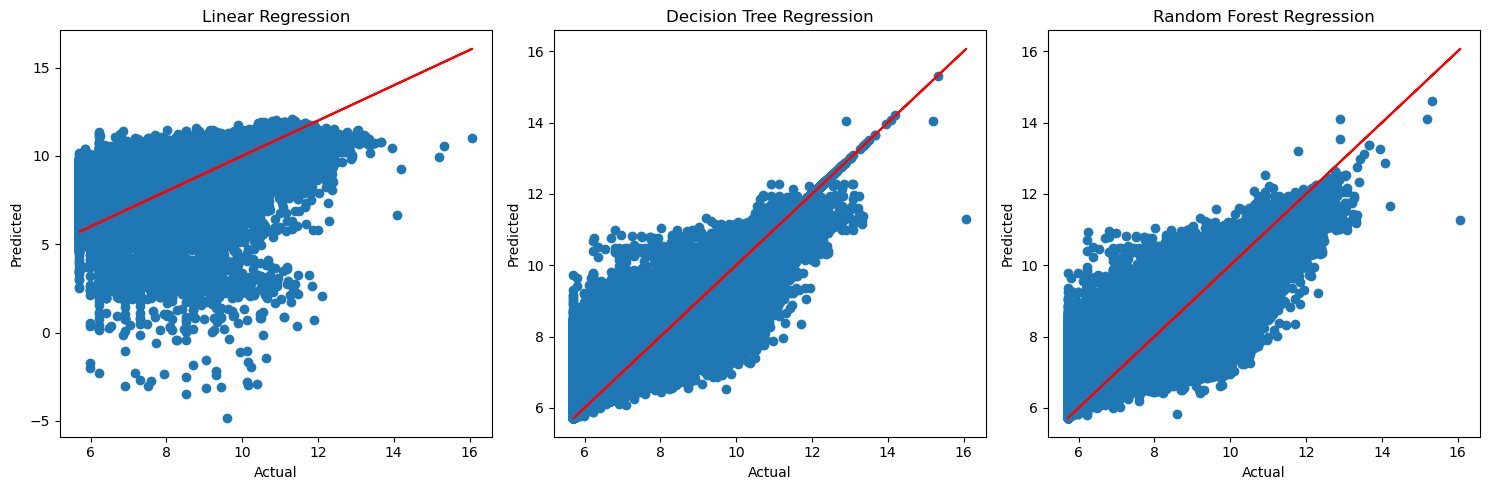

In [60]:
# Get predictions for linear regression model
lin_reg_predictions = lin_reg.predict(registrations_prepared)

# Get predictions for decision tree regression model
tree_reg_predictions = tree_reg.predict(registrations_prepared)

# Get predictions for random forest regression model
forest_reg_predictions = forest_reg.predict(registrations_prepared)

# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot actual vs predicted values for linear regression model
axes[0].scatter(registrations_labels, lin_reg_predictions)
axes[0].plot(registrations_labels, registrations_labels, color='red')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Linear Regression')

# Plot actual vs predicted values for decision tree regression model
axes[1].scatter(registrations_labels, tree_reg_predictions)
axes[1].plot(registrations_labels, registrations_labels, color='red')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Decision Tree Regression')

# Plot actual vs predicted values for random forest regression model
axes[2].scatter(registrations_labels, forest_reg_predictions)
axes[2].plot(registrations_labels, registrations_labels, color='red')
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')
axes[2].set_title('Random Forest Regression')

plt.tight_layout()
plt.show()

In [61]:

models = [lin_reg, tree_reg, forest_reg]
df = evaluate_models(models, registrations_prepared, registrations_labels)
print(df)

     Model      RMSE  2xRMSE $       MAE  R2 Score
0  Model 1  0.794686  4.427489  0.575356  0.558888
1  Model 2  0.357952  2.860794  0.172793  0.910503
2  Model 3  0.456449  3.156919  0.314547  0.854473


Root Mean Squared Error (RMSE): measures the average deviation of the predictions made by a model from the actual values.
2xRMSE is the error band for the model.  
Mean Absolute Error (MAE): similar to RMSE, but without taking the square root, so it is not sensitive to outliers.

The tree model has the lowest RMSE and MAE, and the highest R2 score, which means it has the best performance among the three models. The forest model has slightly higher RMSE and MAE compared to the tree model, but it still has a relatively high R2 score. The linear model has the highest RMSE and MAE, and the lowest R2 score, indicating that it is not a good fit for the data.

Therefore, it can be concluded that the tree model is the best model among the three for predicting the price of used vehicles based on the given features.

Regarding the next steps, you could consider building a model that focuses on specific vehicle models rather than brands or groupings of brands. This could involve exploring the relationship between the maximum value when sold new and the depreciation of the vehicle over time, as well as the impact of scarcity on the price.

Dropping the new_used_U feature may also be a good idea as it is the inverse of new_used_N, which is already included in the dataset.